In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR='D:/DogsVsCats/train'
TEST_DIR='D:/DogsVsCats/test'
IMG_SIZE=50
LR=1e-3

MODEL_NAME='dogsvscats-{}-{}.model'.format(LR,'6conv-basic-video')

In [2]:
def label_img(img):
    word_label=img.split('.')[-3]
    if(word_label=='cat'):
        return [1,0]
    elif(word_label=='dog'):
        return [0,1]

In [3]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_img(img)
        path=os.path.join(TRAIN_DIR,img)
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data

In [14]:
def process_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num=img.split('.')[0]
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img_num])
    np.save('test_data.npy',testing_data)
    return testing_data

In [5]:
train_data=create_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:56<00:00, 445.66it/s]


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()


convnet = input_data(shape=[None, IMG_SIZE,IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded')

In [8]:
train=train_data[:-500]
test=train_data[-500:]

In [9]:
X=np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y=[i[1] for i in train]

test_x=np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y=[i[1] for i in test]

In [12]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.36279 | time: 106.220s
| Adam | epoch: 010 | loss: 0.36279 - acc: 0.8375 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.36405 | time: 107.514s
| Adam | epoch: 010 | loss: 0.36405 - acc: 0.8397 | val_loss: 0.45170 - val_acc: 0.7960 -- iter: 24500/24500
--


In [11]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\Deepthi\dogsvscats-0.001-6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [05:01<00:00, 41.50it/s]


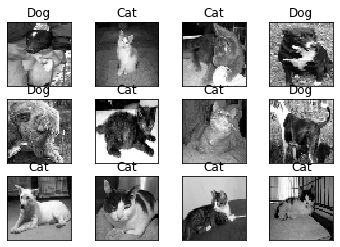

In [15]:
import matplotlib.pyplot as plt
test_data=process_test_data()
#test_data=np.load('test_data.npy')
fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    img_num=data[1]
    img_data=data[0]
    
    y=fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1:str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [19]:
with open('sub-file.csv','w') as f:
    f.write('id,label\n')

In [20]:
with open('sub-file.csv','a') as f:
    for data in tqdm(test_data):
        img_num=data[1]
        img_data=data[0]
        orig=img_data
        data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out=model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))
    


 13%|██████████                                                                  | 1660/12500 [00:06<00:43, 246.55it/s]


 27%|████████████████████▎                                                       | 3347/12500 [00:14<00:37, 243.49it/s]


 40%|██████████████████████████████▍                                             | 5010/12500 [00:21<00:31, 236.84it/s]


 53%|████████████████████████████████████████▌                                   | 6669/12500 [00:28<00:24, 239.75it/s]


 66%|█████████████████████████████████████████████████▉                          | 8220/12500 [00:35<00:19, 215.12it/s]


 78%|███████████████████████████████████████████████████████████▌                | 9790/12500 [00:42<00:12, 211.90it/s]


 90%|███████████████████████████████████████████████████████████████████▋       | 11277/12500 [00:49<00:05, 217.17it/s]


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:55<00:00, 226.44it/s]